# PID control of CartPole 

In [ ]:
!pip install gymnasium[classic-control]
!pip install numpy
!pip install scipy
!pip install matplotlib 

In [ ]:
import gymnasium as gym 
env = gym.make('CartPole-v0', render_mode="human", max_episode_steps=200)

print("action_space", env.action_space)
print("observation_space", env.observation_space)


In [ ]:
import numpy as np 

K = -np.array([1, 1, 1, 1])

In [ ]:
def apply_state_controller(K, x):
    # feedback controller
    <-- YOUR CODE  compute action u -->   # u = -Kx
    
    if u > 0:
        return 1     # if force_dem > 0 -> move cart right
    else:
        return 0     # if force_dem <= 0 -> move cart left

In [ ]:
# get environment
env = gym.make('CartPole-v0', render_mode="human", max_episode_steps=200)

obs, info = env.reset(seed=1)
history = []

for i in range(1000):
    env.render()
    history.append(obs)
    
    <-- YOUR CODE apply state controller -->

    # apply action
    obs, reward, term, trank, info = env.step(action)
    if term or trank:
        print(f'Terminated after {i+1} iterations.')
        break

env.close()

In [ ]:
from matplotlib import pyplot as plt

history = np.asarray(history)

plt.plot(history[:, 0], label="position, m")
plt.plot(history[:, 1], label="velocity, m/s")
plt.plot(history[:, 2], label="angle, rad")
plt.plot(history[:, 3], label="angular velocity, rad/s")

plt.xlabel("Time steps")
plt.title("States")

plt.legend()
plt.show()

# Optimal control of CartPole

This notebook is highly inspired by awesome Paul Brunzema post [1]. 
Classic control is similar to reinforcement learning. The key distinction between them is, that in control we assume to know the underlying system dynamics, whereas in reinforcement learning we do not.

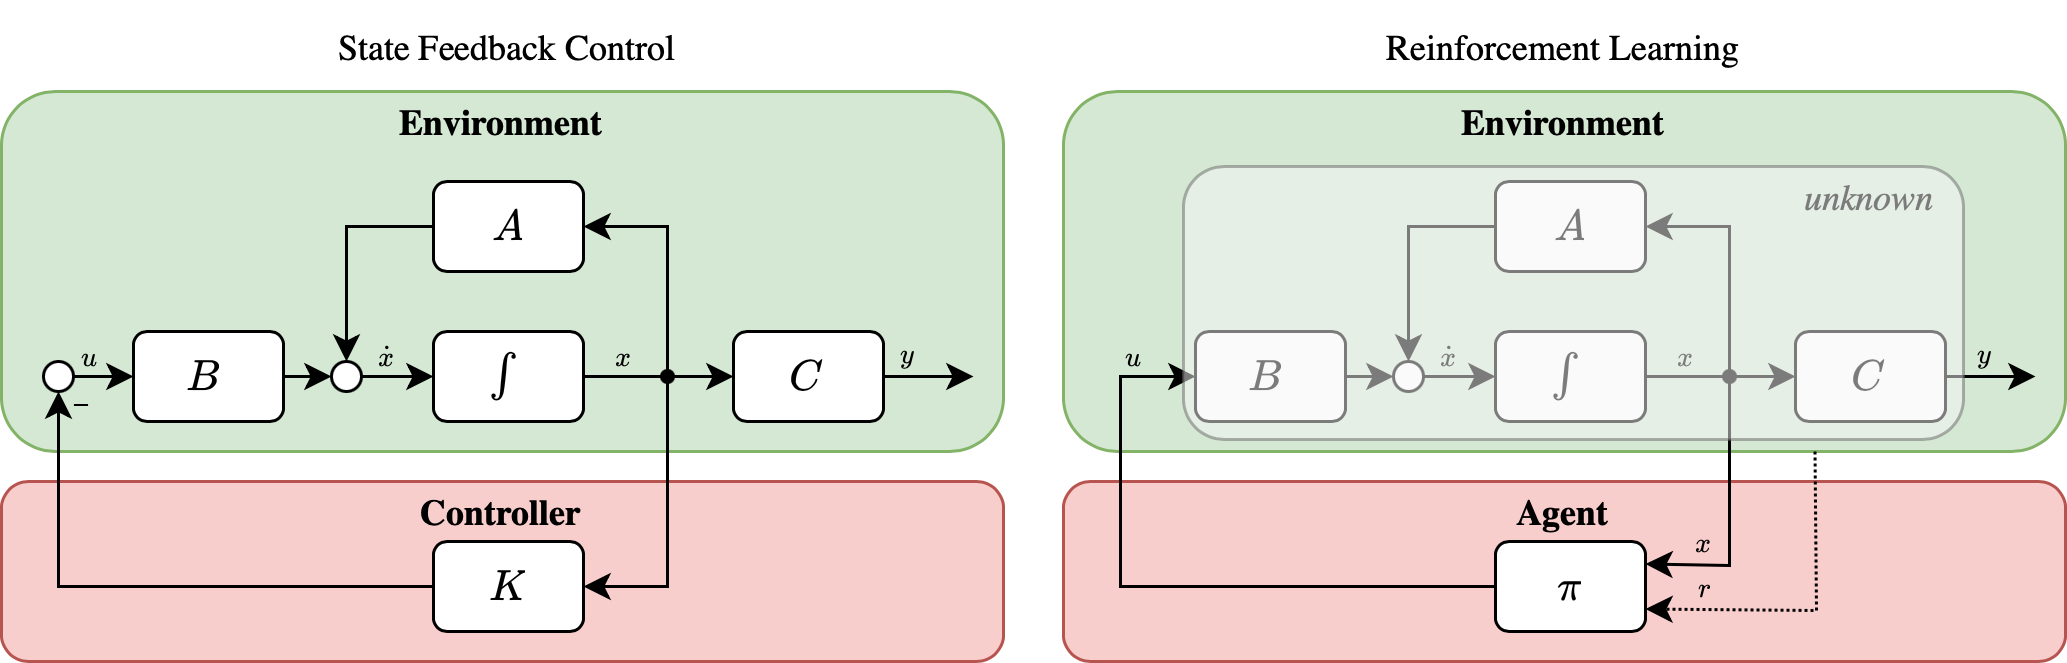

# The Cart-Pole

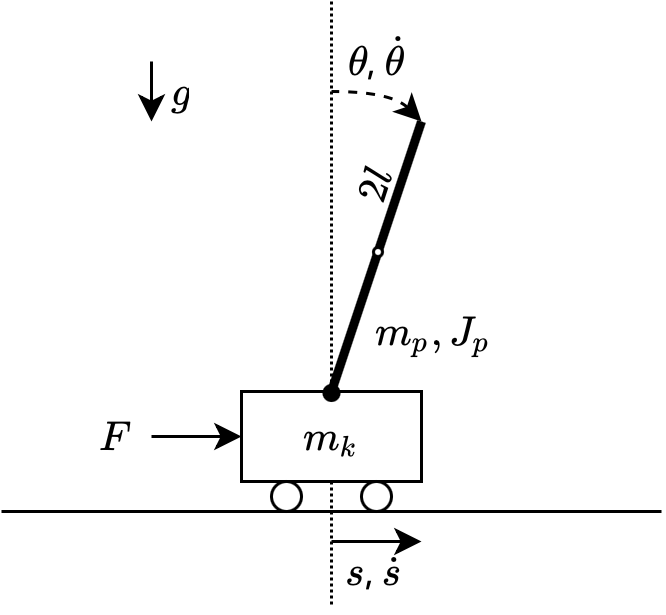

The Cart-Pole consists of a pole, which is connected to a horizontally moving cart. To solve the task, the pole has to be balanced by applying a force F to the cart. The system is nonlinear, since the rotation of the pole introduces trigonometric functions into the force balance equations. Furthermore, the system’s equilibrium with the pole in the up-right position is unstable, as small disturbances will cause the pole to swing down.

The states of the Cart-Pole are the distance s of the cart, the velocity ṡ of the cart, the angle of the pole θ and the angular velocity of the pole θ̇. The parameters are mₚ as the mass of the pole, mₖ as the mass of the cart and Jₚ as the moment of inertia. The equations, which describe the dynamics of the system as they are implemented in the Cart-Pole environment of OpenAI Gym can be seen here.

Now that we have defined our systems and its dynamics, let’s try to control it using optimal control!

# Optimal Control of the Cart-Pole

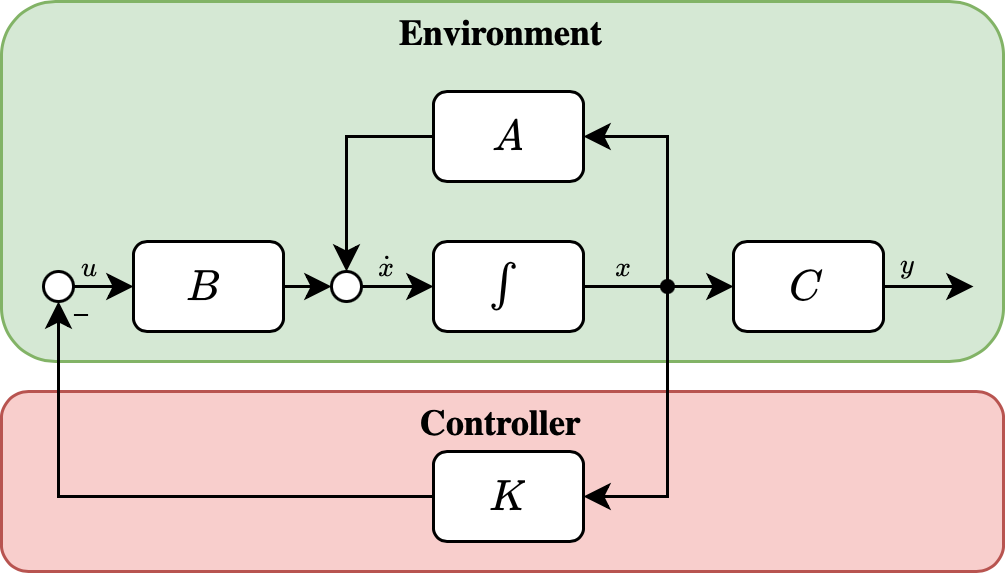

To control the cart we will design a linear quadratic regulator (LQR) which will result in an optimal control gain K. We will feedback the states x of the environment and K will determine our input u into the system – the force F, that we want so apply onto the cart to balance the pole.

However as the name LQR states, we actually need a linear model of our system, but when we analyzed our system we saw it is nonlinear. Fortunately, control has a tool called linearization which corresponds to a first oder Taylor expansion around a desired working point (here’s a video covering the fundamentals of linearization). If we perform linearization around the upper equilibrium of our system where our states x are x = (_s, ṡ, θ, θ̇)ᵀ = (0, 0, 0, 0)_ᵀ __ we obtain a linear system which can be written in state space representation as:



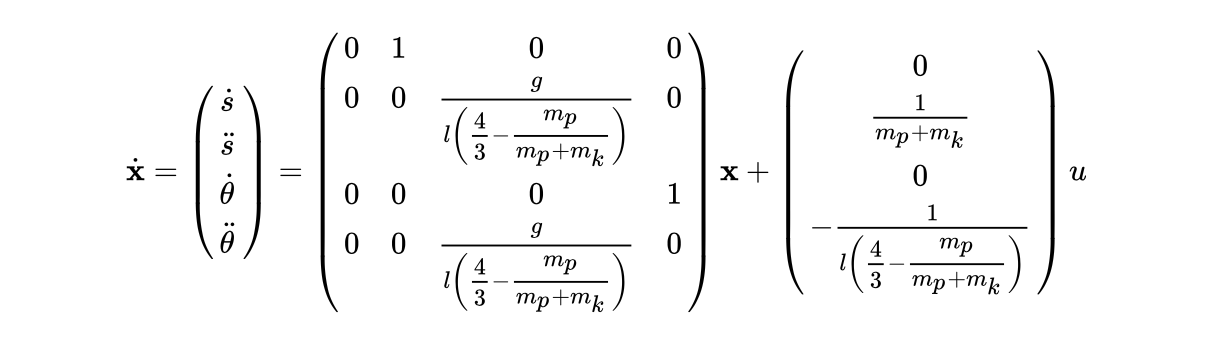

Now that we have our state space representation, we can start with designing the LQR. On a high level, the LQR tries to find an optimal control matrix K by minimizing the cost function below

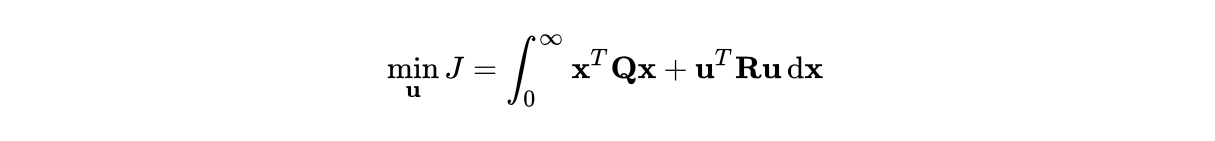

where Q and R are weight matrices, which have to be defined by us. Q states how import performance is and R how expensive the usage of our control is. Therefore, Q and R define, what we actually regard as optimal. Solving this integral looks hard at first, but can be done through partial integration. Since the cost function is quadratic, we know that there exist one unique minimum, which can be found by substituting u =-Kx (see in the figure) and setting the derivative to zero. What we then get is the algebraic Riccati equation:

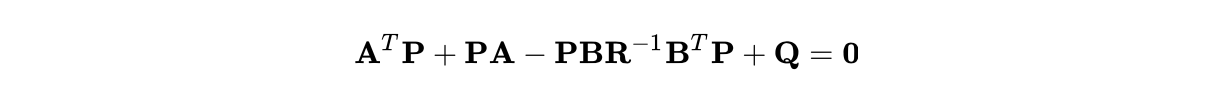

After solving for P we can calculate our controller K as K = inv(R)Bᵀ P. This is all the math we need so, let’s get to the fun part, the application, and look at how we can implement this using Python and OpenAi Gym.

# Lets define the linearized dynamics of the system

In [ ]:
import gymnasium as gym
import numpy as np 
from scipy import linalg

In [ ]:
# state matrix
g = 9.8 # gravity
lp = 0.5 # half the pole's length
mp = 0.1 # mass pole
mk = 1.0 # mass cart
mt = mp + mk # total mass

a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

# Second, lets calculate the optimal controller

In [ ]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)

# get riccati solver

# solve ricatti equation
# Hint: use linalg.solve_continous_are
<-- YOUR CODE solve Riccati equation for P -->

# calculate optimal controller gain.
# K = R^{-1} * B^T P 
<-- YOUR CODE compute K -->

In [ ]:
K

# And last, lets define a function, which we can call to actually calculate the input force F during runtime:

In [ ]:
def apply_state_controller(K, x):
    # feedback controller
    # u = -Kx
    <-- YOUR CODE compute u>
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

# Now we can set up the simulation!

In [ ]:
# get environment
env = gym.make('CartPole-v0', render_mode="human", max_episode_steps=200)
obs, info = env.reset(seed=1)
history = []

for i in range(1000):
    env.render()
    history.append(obs)
    
    # get force direction (action) and force value (force)
    <-- YOUR CODE apply state controller -->
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    
    # change magnitute of the applied force in CartPole
    env.unwrapped.force_mag = abs_force

    # apply action
    obs, reward, term, trank, info = env.step(action)
    if term or trank:
        print(f'Terminated after {i+1} iterations.')
        break

env.close()

In [ ]:
from matplotlib import pyplot as plt

history = np.asarray(history)

plt.plot(history[:, 0], label="position, m")
plt.plot(history[:, 1], label="velocity, m/s")
plt.plot(history[:, 2], label="angle, rad")
plt.plot(history[:, 3], label="angular velocity, rad/s")

plt.xlabel("Time steps")
plt.title("States")

plt.legend()
plt.show()

If we now run the simulation, we can plot our states over the time steps. The Cart-Pole task is considered solved when 199 time steps are reached without falling over. However, since we designed the controller and did not have to learn it, the 199 time steps are always achieved. So lets have a look at the first 400 time steps! What we can observe from the diagram are mainly two things:

1. Our system oscillates. We could have looked at the poles of our closed loop system and see, that we have complex conjugated poles. but I did not want to go into too much detail in the analysis of the system. In fact, we can even choose the poles ourself to have a non oscillating system by using pole placement. However, if we do so, we are no longer guaranteed to solve the task optimally!
All states converge to 0. This is, what we hoped to achieve with our controller.
2. All states converging to zero means, that the system is converging towards the upper equilibrium point around which we linearized it. Therefore, the state feedback controller stabilizes the unstable upper equilibrium point. – So that’s pretty cool!

### Links

1. https://towardsdatascience.com/comparing-optimal-control-and-reinforcement-learning-using-the-cart-pole-swing-up-openai-gym-772636bc48f4/
2. https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
3. https://coneural.org/florian/papers/05_cart_pole.pdf
